<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-a-Layered-Network" data-toc-modified-id="Generate-a-Layered-Network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate a Layered Network</a></span></li></ul></div>

In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

# Generate a Layered Network

In order to see a network with a noticable difference in permeability values in each principle direction, we'll make a network consisting of two distinct layers then stitch them together.  The process of stitching is explained in more detail [here](.../networks/manipulation/stitching_and_merging_networks_together.ipynb).

In [2]:
pn = op.network.Cubic(shape=[8, 8, 8], spacing=30e-6)
pn2 = op.network.Cubic(shape=[24, 24, 8], spacing=10e-6)
pn2['pore.coords'] += [0, 0, 8*30e-6]

In [3]:
pn['pore.coarse'] = True
pn['throat.coarse'] = True
pn2['pore.fine'] = True
pn2['throat.fine'] = True
op.topotools.stitch(network=pn, donor=pn2, P_network=pn.pores('top'), P_donor=pn2.pores('bottom'))

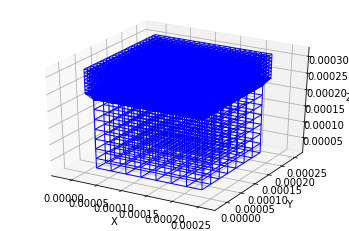

In [4]:
fig = op.topotools.plot_connections(pn)

In [5]:
Ps = pn.pores('fine')
Ts = pn.throats('fine')
geo2 = op.geometry.StickAndBall(network=pn, pores=Ps, throats=Ts)
Ps = pn.pores('coarse')
Ts = pn.throats(['coarse', 'stitched'])
geo1 = op.geometry.StickAndBall(network=pn, pores=Ps, throats=Ts)

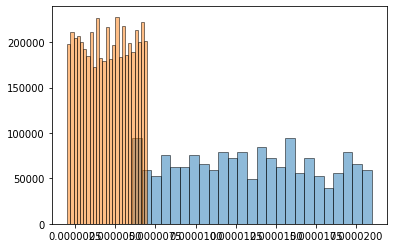

In [6]:
fig = plt.hist(geo1['pore.diameter'], bins=25, density=True, edgecolor='k', alpha=0.5)
fig = plt.hist(geo2['pore.diameter'], bins=25, density=True, edgecolor='k', alpha=0.5)

In [7]:
air = op.phases.Air(network=pn)
phys1 = op.physics.Standard(network=pn, phase=air, geometry=geo1)
phys2 = op.physics.Standard(network=pn, phase=air, geometry=geo2)

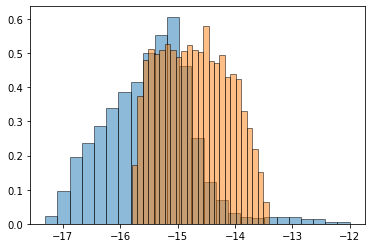

In [8]:
fig = plt.hist(np.log10(phys1['throat.hydraulic_conductance']), bins=25, density=True, edgecolor='k', alpha=0.5)
fig = plt.hist(np.log10(phys2['throat.hydraulic_conductance']), bins=25, density=True, edgecolor='k', alpha=0.5)

In [9]:
sf = op.algorithms.StokesFlow(network=pn, phase=air)
Pin = 1.0
Pout = 0.0
sf.set_value_BC(pores=pn.pores('left'), values=1.0)
sf.set_value_BC(pores=pn.pores('right'), values=0.0)
sf.run()

In [10]:
L = 8 * 30e-6
A = (8 * 30e-6)**2 + (8 * 24)*(10e-6)**2
Q = sf.rate(pores=pn.pores('left'), mode='group')
Kx = Q*L/(A*(Pin - Pout))
print('The permeability coefficient is:', Kx)

The permeability coefficient is: [7.73967466e-09]


In [11]:
sf = op.algorithms.StokesFlow(network=pn, phase=air)
Pin = 1.0
Pout = 0.0
sf.set_value_BC(pores=pn.pores(['top', 'coarse'], mode='and'), values=Pin)
sf.set_value_BC(pores=pn.pores(['top', 'fine'], mode='and'), values=Pout)
sf.run()

In [12]:
A = (8 * 30e-6)**2
L = (8 * 30e-6) + (8 * 10e-6)
Q = sf.rate(pores=pn.pores(['top', 'coarse'], mode='and'), mode='group')
Kz = Q*L/(A*(Pin - Pout))
print('The permeability coefficient is:', Kz)

The permeability coefficient is: [1.54182492e-09]


In [13]:
Kx/Kz

array([5.01981423])

The permeability coefficient for the direction through the 'fine' layer is about 5x lower than the direction parallel to it.  